In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import dt2int

from collections import namedtuple
from scipy.integrate import solve_ivp

In [2]:
# better plots
sns.set_style('whitegrid')

# config
EAT_RATE = 5 # g/min CHO

# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [3]:
# read data
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

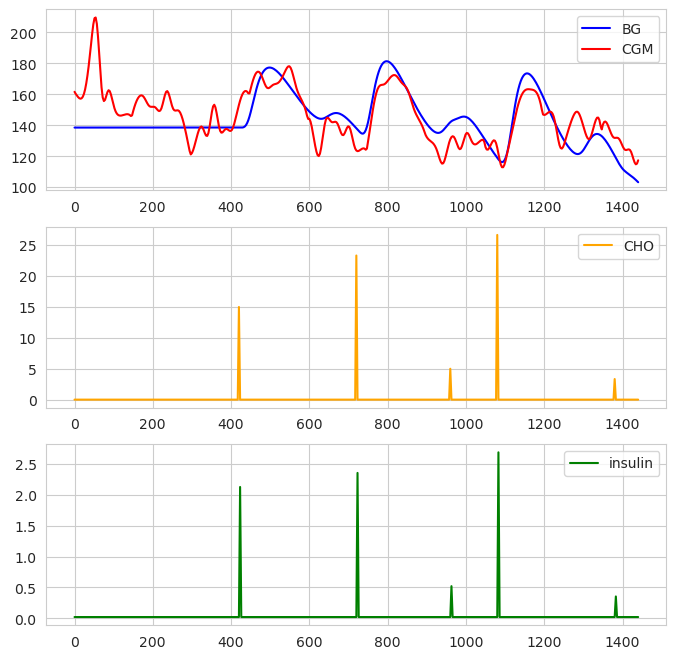

In [4]:
plt.figure(figsize=(8, 8))

plt.subplot(311)
plt.plot(data_t, data_BG, "b", label="BG")
plt.plot(data_t, data_CGM, "r", label="CGM")
plt.legend()

plt.subplot(312)
plt.plot(data_t, data_CHO, "orange", label="CHO")
plt.legend()

plt.subplot(313)
plt.plot(data_t, data_insulin, "g", label="insulin")
plt.legend()

plt.show()

In [5]:
def ode(t, x, inputs, params):
    # desctructure inputs
    in_time, in_CHO, in_insulin = inputs

    # instantiate derivatives
    dxdt = np.zeros(13)

    # get current action
    t_mask = np.abs(in_time - t).argmin()
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    d = action.CHO * 1000 # g -> mg
    insulin = action.insulin * 6000 / params.BW
    basal = in_insulin[0]

    # glucose in the stomach
    qsto = x[0] + x[1]

    last_foodtaken = 0
    if t_mask > 0:
        last_foodtaken = in_CHO[t_mask - 1]
    
    Dbar = last_foodtaken * 1000 # unit: mg

    # stomach solid
    dxdt[0] = -params.kmax * x[0] + d

    if Dbar > 0:
        aa = 5 / 2 / (1 - params.b) / Dbar
        cc = 5 / 2 / params.d / Dbar
        kgut = params.kmin + (params.kmax - params.kmin) / 2 * (
            np.tanh(aa * (qsto - params.b * Dbar))
            - np.tanh(cc * (qsto - params.d * Dbar))
            + 2
        )
    else:
        kgut = params.kmax

    # stomach liquid
    dxdt[1] = params.kmax * x[0] - x[1] * kgut

    # intestine
    dxdt[2] = kgut * x[1] - params.kabs * x[2]

    # Rate of appearance
    Rat = params.f * params.kabs * x[2] / params.BW
    # Glucose Production
    EGPt = params.kp1 - params.kp2 * x[3] - params.kp3 * x[8]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    if x[3] > params.ke2:
        Et = params.ke1 * (x[3] - params.ke2)
    else:
        Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - params.k1 * x[3] + params.k2 * x[4]
    dxdt[3] = (x[3] >= 0) * dxdt[3]

    Vmt = params.Vm0 + params.Vmx * x[6]
    Kmt = params.Km0
    Uidt = Vmt * x[4] / (Kmt + x[4])
    dxdt[4] = -Uidt + params.k1 * x[3] - params.k2 * x[4]
    dxdt[4] = (x[4] >= 0) * dxdt[4]

    # insulin kinetics
    dxdt[5] = (
        -(params.m2 + params.m4) * x[5]
        + params.m1 * x[9]
        + params.ka1 * x[10]
        + params.ka2 * x[11]
    )  # plus insulin IV injection u[3] if needed
    It = x[5] / params.Vi
    dxdt[5] = (x[5] >= 0) * dxdt[5]

    # insulin action on glucose utilization
    dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

    # insulin action on production
    dxdt[7] = -params.ki * (x[7] - It)

    dxdt[8] = -params.ki * (x[8] - x[7])

    # insulin in the liver (pmol/kg)
    dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
    dxdt[9] = (x[9] >= 0) * dxdt[9]

    # subcutaneous insulin kinetics
    dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
    dxdt[10] = (x[10] >= 0) * dxdt[10]

    dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
    dxdt[11] = (x[11] >= 0) * dxdt[11]

    # subcutaneous glucose
    dxdt[12] = -params.ksc * x[12] + params.ksc * x[3]
    dxdt[12] = (x[12] >= 0) * dxdt[12]

    return dxdt

In [6]:
# load parameters
orig_params = pd.read_csv("../simglucose/simglucose/params/vpatient_params.csv")
params = orig_params.loc[orig_params["Name"] == "adult#001"].squeeze()

In [7]:
# timespan
t_span = (data_t[0], data_t[-1])
t_eval = data_t

In [8]:
# initial conditions
u0 = params.iloc[2:15].to_numpy()

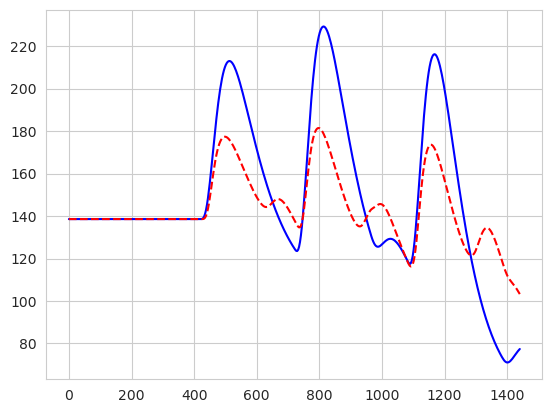

In [9]:
sol = solve_ivp(ode, t_span, u0, t_eval=t_eval, args=((data_t, data_CHO, data_insulin), params))
sol_BG = sol.y[12] / params.Vg

plt.plot(sol.t, sol_BG, "b", label="sim")
plt.plot(data_t, data_BG, "r--", label="act")
plt.show()

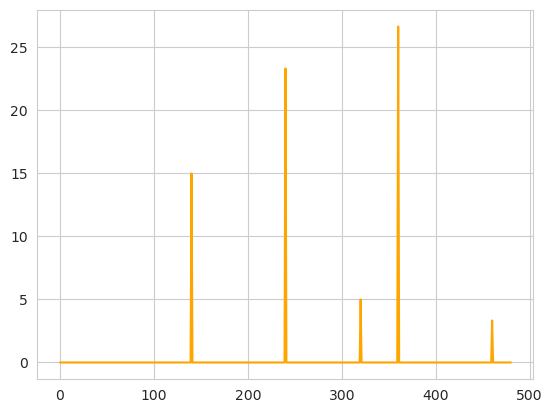

In [10]:
plt.plot(data_CHO, "orange")
plt.show()

In [11]:
data_t[data_CHO > data_CHO[0]]

array([ 420.,  720.,  960., 1080., 1380.])

In [12]:
data_t[data_insulin > data_insulin[0]]

array([ 423.,  723.,  963., 1083., 1383.])

In [13]:
data_CHO[data_t == 417]

array([0.])

In [14]:
data_t

array([   0.,    3.,    6.,    9.,   12.,   15.,   18.,   21.,   24.,
         27.,   30.,   33.,   36.,   39.,   42.,   45.,   48.,   51.,
         54.,   57.,   60.,   63.,   66.,   69.,   72.,   75.,   78.,
         81.,   84.,   87.,   90.,   93.,   96.,   99.,  102.,  105.,
        108.,  111.,  114.,  117.,  120.,  123.,  126.,  129.,  132.,
        135.,  138.,  141.,  144.,  147.,  150.,  153.,  156.,  159.,
        162.,  165.,  168.,  171.,  174.,  177.,  180.,  183.,  186.,
        189.,  192.,  195.,  198.,  201.,  204.,  207.,  210.,  213.,
        216.,  219.,  222.,  225.,  228.,  231.,  234.,  237.,  240.,
        243.,  246.,  249.,  252.,  255.,  258.,  261.,  264.,  267.,
        270.,  273.,  276.,  279.,  282.,  285.,  288.,  291.,  294.,
        297.,  300.,  303.,  306.,  309.,  312.,  315.,  318.,  321.,
        324.,  327.,  330.,  333.,  336.,  339.,  342.,  345.,  348.,
        351.,  354.,  357.,  360.,  363.,  366.,  369.,  372.,  375.,
        378.,  381.,

In [15]:
cont_time = np.arange(data_t[0], data_t[-1])

In [16]:
cont_time[-1]

1439.0

In [17]:
# process events
import re

with open("events.txt") as f:
    events = f.readlines()

events = list(map(lambda l: l.strip(), events))
events = list(map(lambda l: l.split("t1dpatient:")[-1], events))
# events = list(map(lambda l: l.split(","), events))
# events = list(map(lambda l: [l[0], l[1].strip()], events))

FileNotFoundError: [Errno 2] No such file or directory: 'events.txt'

In [ ]:
events

['t = 420.0, patient starts eating ...',
 't = 420.0, patient eats 5 g',
 't = 421.0, patient eats 5 g',
 't = 422.0, patient eats 5 g',
 't = 423.0, patient eats 5 g',
 't = 423.0, injecting insulin: [1.06345]',
 't = 423.0854334916434, injecting insulin: [1.06345]',
 't = 423.12815023746515, injecting insulin: [1.06345]',
 't = 423.3417339665737, injecting insulin: [1.06345]',
 't = 423.37970440730413, injecting insulin: [1.06345]',
 't = 423.4271674582171, injecting insulin: [1.06345]',
 't = 423.4271674582171, injecting insulin: [1.06345]',
 't = 423.0420331788428, injecting insulin: [1.06345]',
 't = 423.06304976826425, injecting insulin: [1.06345]',
 't = 423.16813271537126, injecting insulin: [1.06345]',
 't = 423.1868141281903, injecting insulin: [1.06345]',
 't = 423.2101658942141, injecting insulin: [1.06345]',
 't = 423.2101658942141, injecting insulin: [1.06345]',
 't = 423.0266280801352, injecting insulin: [1.06345]',
 't = 423.0399421202028, injecting insulin: [1.06345]',

In [ ]:
CHO_events = [] # [[data_t[0], data_CHO[-1]]]
insulin_events = [] # [[data_t[0], data_insulin[-1]]]

for e in events:
    t_event = re.findall("t = ([\d\.]+)", e)[0]
    CHO_event = re.findall("patient eats ([\d\.]+) g", e)
    insulin_event = re.findall("injecting insulin: .([\d\.]+).", e)

    if len(CHO_event):
        CHO_events.append([float(t_event), float(CHO_event[0])])
    
    if len(insulin_event):
        insulin_events.append([float(t_event), float(insulin_event[0])])

CHO_events = np.array(CHO_events)
insulin_events = np.array(insulin_events)

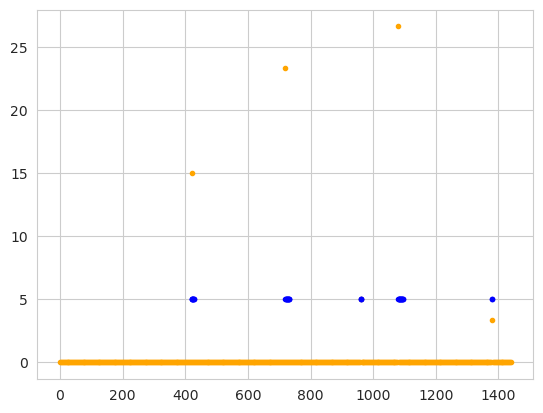

In [ ]:
plt.plot(data_t, data_CHO, "." , color="orange")
plt.plot(CHO_events[:, 0], CHO_events[:, 1], ".", color="blue")
plt.show()

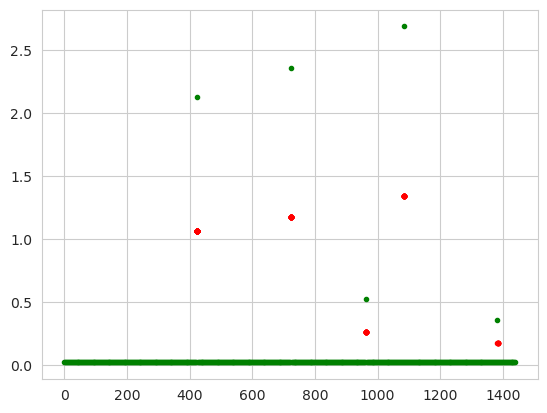

In [ ]:
plt.plot(data_t, data_insulin, "." , color="green")
plt.plot(insulin_events[:, 0], insulin_events[:, 1], ".", color="red")
plt.show()

In [ ]:
t_i, t_f = 410, 450
data_mask = (data_t > t_i) & (data_t < t_f)
CHO_mask = (CHO_events[:, 0] > t_i) & (CHO_events[:, 0] < t_f)
insulin_mask = (insulin_events[:, 0] > t_i) & (insulin_events[:, 0] < t_f)

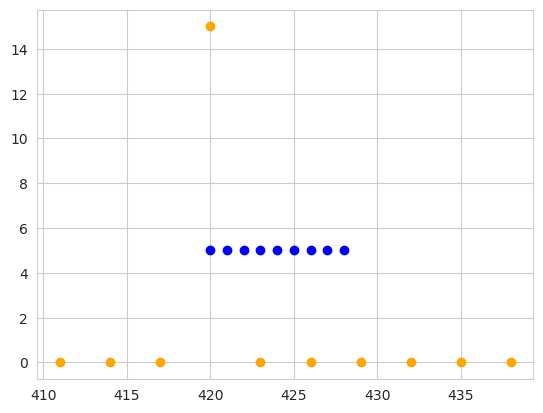

In [ ]:
plt.scatter(data_t[data_mask], data_CHO[data_mask], color="orange")
plt.scatter(CHO_events[:, 0][CHO_mask], CHO_events[:, 1][CHO_mask], color="blue")
plt.show()

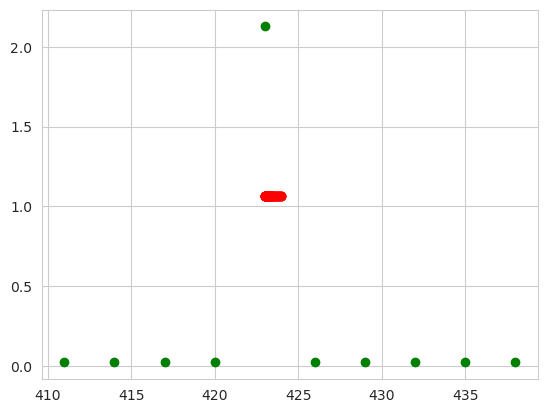

In [ ]:
plt.scatter(data_t[data_mask], data_insulin[data_mask], color="green")
plt.scatter(insulin_events[:, 0][insulin_mask], insulin_events[:, 1][insulin_mask], color="red")
plt.show()

In [ ]:
insulin_events[insulin_mask]

array([[423.        ,   1.06345   ],
       [423.08543349,   1.06345   ],
       [423.12815024,   1.06345   ],
       [423.34173397,   1.06345   ],
       [423.37970441,   1.06345   ],
       [423.42716746,   1.06345   ],
       [423.42716746,   1.06345   ],
       [423.04203318,   1.06345   ],
       [423.06304977,   1.06345   ],
       [423.16813272,   1.06345   ],
       [423.18681413,   1.06345   ],
       [423.21016589,   1.06345   ],
       [423.21016589,   1.06345   ],
       [423.02662808,   1.06345   ],
       [423.03994212,   1.06345   ],
       [423.10651232,   1.06345   ],
       [423.11834702,   1.06345   ],
       [423.1331404 ,   1.06345   ],
       [423.1331404 ,   1.06345   ],
       [423.01987829,   1.06345   ],
       [423.02981744,   1.06345   ],
       [423.07951317,   1.06345   ],
       [423.08834797,   1.06345   ],
       [423.09939146,   1.06345   ],
       [423.09939146,   1.06345   ],
       [423.01657529,   1.06345   ],
       [423.02486294,   1.06345   ],
 

In [ ]:
data_insulin[data_mask]

array([0.021125, 0.021125, 0.021125, 0.021125, 2.1269  , 0.021125,
       0.021125, 0.021125, 0.021125, 0.021125])

In [ ]:
2.1269 / 1.06345

2.0

In [ ]:
data_CHO[data_mask]

array([ 0.,  0.,  0., 15.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
CHO_events[CHO_mask]

array([[420.,   5.],
       [421.,   5.],
       [422.,   5.],
       [423.,   5.],
       [424.,   5.],
       [425.,   5.],
       [426.,   5.],
       [427.,   5.],
       [428.,   5.]])

In [ ]:
# insulin: pump (ins / 2) from t = t_inj till t_inj + 1 min

In [ ]:
# CHO: injest (CHO * 3) at each minute from t = t_inj till it finishes

In [ ]:
t_processed = np.arange(data_t[0], data_t[-1])
CHO_processed = np.ones_like(t_processed) * data_CHO[0]
ins_processed = np.ones_like(t_processed) * data_insulin[0]

In [ ]:
for t_i in range(len(t_processed)):
    idx = np.abs(data_t - t_i).argmin()
    

In [ ]:
t_i = 400
data_CHO[np.argmin(data_t - t_i)]

0.0

In [ ]:
np.abs(data_t - t_i).argmin()

133

In [ ]:
data_CHO[480]

0.0

In [ ]:
EAT_RATE = 5
SAMPLE_TIME = 3

processed_CHO = []

i = 0
while i < len(data_CHO):
    if data_CHO[i] > data_CHO[0]:
        current_CHO = data_CHO[i]
        while current_CHO > 0:
            processed_CHO.append(EAT_RATE)
            current_CHO -= EAT_RATE
            i += 1
    else:
        processed_CHO.append(data_CHO[i])
        i += 1

processed_CHO = np.array(processed_CHO)

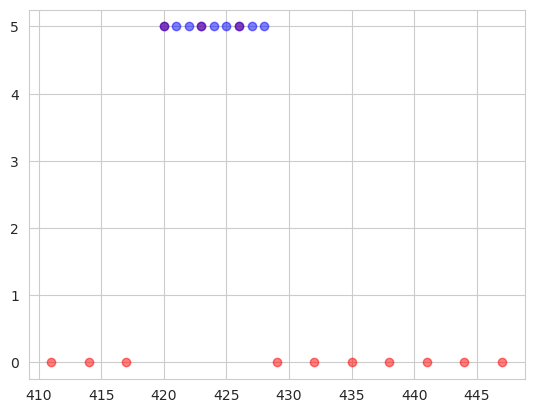

In [ ]:
plt.scatter(data_t[data_mask], processed_CHO[data_mask], color="red", alpha=0.5)
plt.scatter(CHO_events[:, 0][CHO_mask], CHO_events[:, 1][CHO_mask], color="blue", alpha=0.5)
plt.show()

In [ ]:
data_t[data_mask]

array([411., 414., 417., 420., 423., 426., 429., 432., 435., 438., 441.,
       444., 447.])

In [ ]:
CHO_events[:, 0]

array([ 420.,  421.,  422.,  423.,  424.,  425.,  426.,  427.,  428.,
        720.,  721.,  722.,  723.,  724.,  725.,  726.,  727.,  728.,
        729.,  730.,  731.,  732.,  960.,  961.,  962., 1080., 1081.,
       1082., 1083., 1084., 1085., 1086., 1087., 1088., 1089., 1090.,
       1091., 1092., 1093., 1094., 1095., 1380., 1381.])

In [ ]:
processed_CHO.shape

(481,)

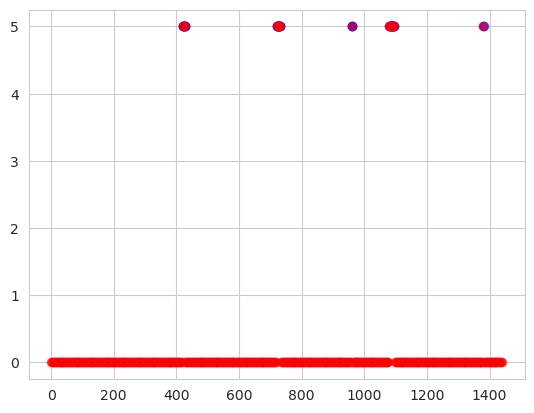

In [ ]:
plt.scatter(CHO_events[:, 0], CHO_events[:, 1], color="blue", alpha=0.5)
plt.scatter(data_t, processed_CHO, color="red", alpha=0.5)
plt.show()

In [ ]:
processed_insulin = []

i = 0
while i < len(data_insulin):
    if data_insulin[i] > data_insulin[0]:
        current_insulin = data_insulin[i]
        processed_insulin.append(current_insulin / 2)
        processed_insulin.append(current_insulin / 2)
        i += 2
    else:
        processed_insulin.append(data_insulin[i])
        i += 1

processed_insulin = np.array(processed_insulin)

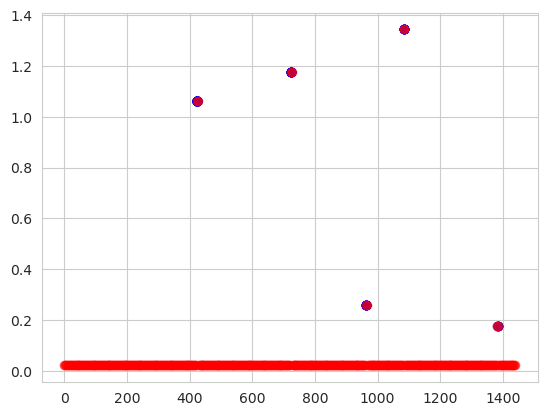

In [ ]:
plt.scatter(insulin_events[:, 0], insulin_events[:, 1], color="blue", alpha=0.5)
plt.scatter(data_t, processed_insulin, color="red", alpha=0.5)
plt.show()

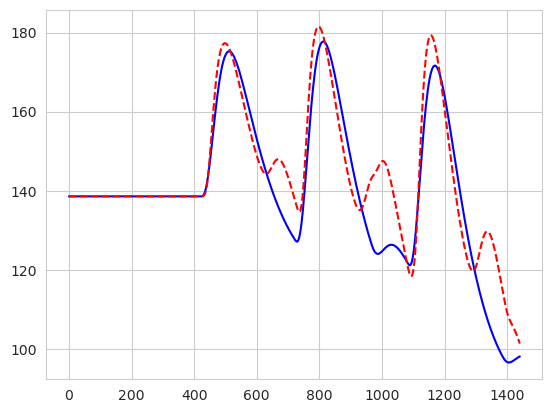

In [ ]:
proc_insulin = np.where(data_insulin > data_insulin[0], data_insulin / 2, data_insulin)
sol = solve_ivp(ode, t_span, u0, t_eval=t_eval, args=((data_t, data_CHO / 2, proc_insulin), params))
sol_BG = sol.y[12] / params.Vg

plt.plot(sol.t, sol_BG, "b", label="sim")
plt.plot(data_t, data_BG, "r--", label="act")
plt.show()

In [ ]:
np.arange(*t_span)

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.437e+03, 1.438e+03,
       1.439e+03])